In [6]:
import numpy as np
import re

import pandas as pd
from ordered_set import OrderedSet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import m1

<h1>Bag of words -- Page #12 - #17</h1>

In [7]:
def create_stem_cache(cleaned_description):
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache

In [8]:
def create_custom_preprocessor(stop_dict, stem_cache):
    def custom_preprocessor(s):
        ps = PorterStemmer()
        s = re.sub(r'[^A-Za-z]', ' ', s)
        s = re.sub(r'\s+', ' ', s)
        s = word_tokenize(s)
        s = list(OrderedSet(s) - stop_dict)
        s = [word for word in s if len(word)>2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = ' '.join(s)
        return s
    return custom_preprocessor

In [9]:
def sk_vectorize(texts, cleaned_description, stop_dict, stem_cache):
    my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
    vectorizer.fit(cleaned_description)
    query = vectorizer.transform(texts)
    print(query)
    print(vectorizer.inverse_transform(query))


In [10]:
cleaned_description = m1.get_and_clean_data()
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words('English'))


In [6]:
my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
bigram_vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor, ngram_range=(1,2))
bigram_vectorizer.fit(cleaned_description)
print(len(bigram_vectorizer.get_feature_names_out()))

396338


In [7]:
trigram_vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor, ngram_range=(1,3))
trigram_vectorizer.fit(cleaned_description)
print(len(trigram_vectorizer.get_feature_names_out()))

1103601


<h1>Tf-idf -- Page #25</h1>

In [8]:
vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
vectorizer.fit(cleaned_description)
X = vectorizer.transform(cleaned_description)
N = len(cleaned_description)

df = np.array((X.todense() > 0).sum(0))[0] # Contain the terms or not => True or False ( Turns value that lager than 1 into 1 )
idf = np.log10(1+(N / df)) #
tf = np.log10(X.todense() + 1)

tf_idf = np.multiply(tf, idf)

X = sparse.csr_matrix(tf_idf)
print(X.toarray())

X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

max_term = X_df.sum().sort_values()[-20:].sort_index().index

print(X_df[max_term].to_markdown())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|      |   applic |   commun |   design |   develop |   employ |    experi |   includ |    manag |   product |   program |   provid |   requir |   respons |   support |   system |     team |   technolog |     test |      use |      work |
|-----:|---------:|---------:|---------:|----------:|---------:|----------:|---------:|---------:|----------:|----------:|---------:|---------:|----------:|----------:|---------:|---------:|------------:|---------:|---------:|----------:|
|    0 | 0.16281  | 0.203833 | 0.169439 | 0.183138  | 0.137024 | 0.0958075 | 0.122223 | 0.202949 |  0.134365 |  0.12785  | 0.127158 | 0.105262 |  0.120846 |  0        | 0        | 0.105974 |    0.113112 | 0.236987 | 0.189653 | 0.0967069 |
|    1 | 0.102722 | 0.128604 | 0.106904 | 0.145133  | 0        | 0.0958075 | 0        | 0.128046 |  0        |  0        | 0   

In [9]:
X_df[X_df.sum().sort_values()[-15:].index].iloc[:10]

includ     manag   respons       use    employ      team    provid  \
0  0.122223  0.202949  0.120846  0.189653  0.137024  0.105974  0.127158   
1  0.000000  0.128046  0.120846  0.000000  0.000000  0.105974  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.137024  0.105974  0.127158   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.167965  0.127158   
4  0.000000  0.128046  0.120846  0.000000  0.000000  0.105974  0.000000   
5  0.000000  0.000000  0.120846  0.000000  0.217178  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.119658  0.000000  0.167965  0.000000   
7  0.000000  0.128046  0.120846  0.189653  0.000000  0.211949  0.000000   
8  0.122223  0.128046  0.120846  0.119658  0.217178  0.105974  0.201541   
9  0.193719  0.000000  0.120846  0.119658  0.000000  0.167965  0.127158   

     system  technolog      test    design    requir      work    applic  \
0  0.000000   0.113112  0.236987  0.169439  0.105262  0.096707  0.162810   
1  0.000000   0.179279  0.000000  0.106904  0.105262  0.096707  0.102722   
2  0.114391   0.000000  0.187808  0.000000  0.105262  0.153277  0.162810   
3  0.114391   0.000000  0.118493  0.000000  0.000000  0.096707  0.000000   
4  0.000000   0.179279  0.000000  0.106904  0.105262  0.096707  0.102722   
5  0.000000   0.113112  0.000000  0.106904  0.105262  0.000000  0.162810   
6  0.114391   0.113112  0.000000  0.106904  0.105262  0.096707  0.102722   
7  0.114391   0.113112  0.187808  0.106904  0.105262  0.153277  0.102722   
8  0.181305   0.179279  0.187808  0.106904  0.166836  0.153277  0.205443   
9  0.114391   0.113112  0.118493  0.106904  0.105262  0.000000  0.000000   

    develop  
0  0.183138  
1  0.145133  
2  0.145133  
3  0.145133  
4  0.145133  
5  0.145133  
6  0.145133  
7  0.212616  
8  0.183138  
9  0.145133

<h1>Activity -- Page # 27</h1>

In [10]:
bigram_vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor, ngram_range=(2,2))
bigram_vectorizer.fit(cleaned_description)
X = bigram_vectorizer.transform(cleaned_description)
N = len(cleaned_description)

df = np.array((X.todense() > 0).sum(0))[0]
idf = np.log10(1+(N / df))
tf = np.log10(X.todense() + 1)

tf_idf = np.multiply(tf, idf)

X = sparse.csr_matrix(tf_idf)
print(X.toarray())

X_df = pd.DataFrame(X.toarray(), columns=bigram_vectorizer.get_feature_names_out())

max_term = X_df.sum().sort_values()[-20:].sort_index().index

print(X_df[max_term].to_markdown())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|      |   bachelor degre |   color religion |   comput scienc |   degre comput |   design develop |   equal employ |   gender ident |   nation origin |   orient gender |   peopl say |   qualifi applic |   race color |   read peopl |   regard race |   say work |   sexual orient |   softwar develop |   veteran statu |   without regard |   year experi |
|-----:|-----------------:|-----------------:|----------------:|---------------:|-----------------:|---------------:|---------------:|----------------:|----------------:|------------:|-----------------:|-------------:|-------------:|--------------:|-----------:|----------------:|------------------:|----------------:|-----------------:|--------------:|
|    0 |         0        |         0.213943 |        0.164126 |         0      |         0        |       0.240992 |       0.214809 |  

In [12]:
X_df[max_term]

bachelor degre  color religion  comput scienc  degre comput  \
0           0.000000        0.213943       0.164126        0.0000   
1           0.000000        0.000000       0.000000        0.0000   
2           0.000000        0.213943       0.000000        0.0000   
3           0.000000        0.000000       0.000000        0.0000   
4           0.000000        0.000000       0.000000        0.0000   
...              ...             ...            ...           ...   
7578        0.168525        0.000000       0.164126        0.0000   
7579        0.000000        0.213943       0.000000        0.0000   
7580        0.000000        0.000000       0.000000        0.0000   
7581        0.000000        0.000000       0.164126        0.0000   
7582        0.168525        0.000000       0.164126        0.2151   

      design develop  equal employ  gender ident  nation origin  \
0           0.000000      0.240992      0.214809       0.191082   
1           0.000000      0.000000      0.000000       0.000000   
2           0.000000      0.240992      0.000000       0.191082   
3           0.000000      0.000000      0.000000       0.000000   
4           0.000000      0.000000      0.000000       0.000000   
...              ...           ...           ...            ...   
7578        0.000000      0.000000      0.000000       0.000000   
7579        0.219148      0.000000      0.214809       0.191082   
7580        0.000000      0.000000      0.000000       0.000000   
7581        0.000000      0.000000      0.000000       0.000000   
7582        0.219148      0.240992      0.000000       0.000000   

      orient gender  peopl say  qualifi applic  race color  read peopl  \
0          0.236177        0.0        0.000000     0.00000         0.0   
1          0.000000        0.0        0.000000     0.00000         0.0   
2          0.000000        0.0        0.249122     0.20557         0.0   
3          0.000000        0.0        0.000000     0.00000         0.0   
4          0.000000        0.0        0.000000     0.00000         0.0   
...             ...        ...             ...         ...         ...   
7578       0.000000        0.0        0.000000     0.00000         0.0   
7579       0.236177        0.0        0.249122     0.20557         0.0   
7580       0.000000        0.0        0.000000     0.00000         0.0   
7581       0.000000        0.0        0.000000     0.00000         0.0   
7582       0.000000        0.0        0.000000     0.00000         0.0   

      regard race  say work  sexual orient  softwar develop  veteran statu  \
0        0.217938       0.0       0.186518         0.132351       0.233432   
1        0.000000       0.0       0.000000         0.132351       0.000000   
2        0.217938       0.0       0.000000         0.132351       0.233432   
3        0.000000       0.0       0.000000         0.132351       0.000000   
4        0.000000       0.0       0.000000         0.132351       0.000000   
...           ...       ...            ...              ...            ...   
7578     0.000000       0.0       0.000000         0.000000       0.000000   
7579     0.217938       0.0       0.186518         0.000000       0.233432   
7580     0.000000       0.0       0.000000         0.000000       0.000000   
7581     0.000000       0.0       0.000000         0.132351       0.000000   
7582     0.000000       0.0       0.000000         0.132351       0.000000   

      without regard  year experi  
0           0.213428          0.0  
1           0.000000          0.0  
2           0.213428          0.0  
3           0.000000          0.0  
4           0.000000          0.0  
...              ...          ...  
7578        0.000000          0.0  
7579        0.213428          0.0  
7580        0.000000          0.0  
7581        0.000000          0.0  
7582        0.000000          0.0  

[7583 rows x 20 columns]

<h1>Tf - idf page #39 - #42</h1>

In [67]:
arr = np.array([[100, 200, 200, 50],[90,200, 300, 0], [5, 200, 10, 200]])

data = pd.DataFrame(arr, index=['DevOpsHandbook', 'ContinuousDelivery', 'DistributedComputing'], columns=['business','computer','git','parallel'])
data = np.log10(data + 1)

data

business  computer       git  parallel
DevOpsHandbook        2.004321  2.303196  2.303196  1.707570
ContinuousDelivery    1.959041  2.303196  2.478566  0.000000
DistributedComputing  0.778151  2.303196  1.041393  2.303196

In [69]:
data.loc['DevOpsHandbook']

business    2.004321
computer    2.303196
git         2.303196
parallel    1.707570
Name: DevOpsHandbook, dtype: float64

In [70]:
data.loc['ContinuousDelivery']

business    1.959041
computer    2.303196
git         2.478566
parallel    0.000000
Name: ContinuousDelivery, dtype: float64

In [71]:
data.loc['DistributedComputing']

business    0.778151
computer    2.303196
git         1.041393
parallel    2.303196
Name: DistributedComputing, dtype: float64

In [72]:
print(data.loc['DevOpsHandbook'].dot(data.loc['ContinuousDelivery']))
print(data.loc['DevOpsHandbook'].dot(data.loc['DistributedComputing']))
print(data.loc['ContinuousDelivery'].dot(data.loc['DistributedComputing']))

14.939885194377617
13.195777686137447
9.410303606094942


In [73]:
data.loc['DevOpsHandbook'] /= np.sqrt((data.loc['DevOpsHandbook'] ** 2).sum())
data.loc['ContinuousDelivery'] /= np.sqrt((data.loc['ContinuousDelivery'] ** 2).sum())
data.loc['DistributedComputing'] /= np.sqrt((data.loc['DistributedComputing'] ** 2).sum())
print(data.to_markdown())

|                      |   business |   computer |      git |   parallel |
|:---------------------|-----------:|-----------:|---------:|-----------:|
| DevOpsHandbook       |   0.478543 |   0.549901 | 0.549901 |   0.407692 |
| ContinuousDelivery   |   0.501071 |   0.589096 | 0.633951 |   0        |
| DistributedComputing |   0.221882 |   0.656732 | 0.296942 |   0.656732 |


In [75]:
print(data.loc['DevOpsHandbook'].dot(data.loc['ContinuousDelivery']))
print(data.loc['DevOpsHandbook'].dot(data.loc['DistributedComputing']))
print(data.loc['ContinuousDelivery'].dot(data.loc['DistributedComputing']))

0.9123394651809295
0.8983513789958276
0.6863034317623423


<h1>Small Workout Page #43</h1>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
my_custom_preprocessor = create_custom_preprocessor(stop_dict,stem_cache)
tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True, ngram_range=(2,2))
tf_idf_vectorizer.fit(cleaned_description)
transformed_data = tf_idf_vectorizer.transform(cleaned_description)
X_tfidf_df = pd.DataFrame(transformed_data.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
max_term = X_tfidf_df.sum().sort_values()[-10:].sort_index().index
X_tfidf_df[max_term].head(5)

bachelor degre  color religion  comput scienc  design develop  \
0             0.0        0.023682        0.01879             0.0   
1             0.0        0.000000        0.00000             0.0   
2             0.0        0.025711        0.00000             0.0   
3             0.0        0.000000        0.00000             0.0   
4             0.0        0.000000        0.00000             0.0   

   nation origin  race color  read peopl  say work  sexual orient  \
0       0.021508     0.00000         0.0       0.0       0.021061   
1       0.000000     0.00000         0.0       0.0       0.000000   
2       0.023352     0.02486         0.0       0.0       0.000000   
3       0.000000     0.00000         0.0       0.0       0.000000   
4       0.000000     0.00000         0.0       0.0       0.000000   

   softwar develop  
0         0.015276  
1         0.019460  
2         0.016585  
3         0.019642  
4         0.019499

In [12]:
(X_tfidf_df**2).sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7578    1.0
7579    1.0
7580    1.0
7581    1.0
7582    1.0
Length: 7583, dtype: float64

In [13]:
query =['aws devops']

In [14]:
transformed_query = tf_idf_vectorizer.transform(query)

In [15]:
transformed_query_df = pd.DataFrame(transformed_query.toarray(),columns=tf_idf_vectorizer.get_feature_names_out()).loc[0]

In [16]:
transformed_query_df.loc[transformed_query_df>0]

aw devop    1.0
Name: 0, dtype: float64

In [17]:
q_dot_d = X_tfidf_df.dot(transformed_query_df.T)

In [18]:
q_dot_d

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7578    0.0
7579    0.0
7580    0.0
7581    0.0
7582    0.0
Length: 7583, dtype: float64

In [19]:
print(cleaned_description.iloc[np.argsort(q_dot_d)[::-1][:5].values])

2244    we have a great opportunity for a cleared soft...
3300    sr software developer in san diego ca sr softw...
4604    read what people are saying about working here...
2908    3051  4621 an hour  job overview  restricted p...
2896    read what people are saying about working here...
Name: job_description, dtype: object


In [127]:
import matplotlib.pyplot as plt

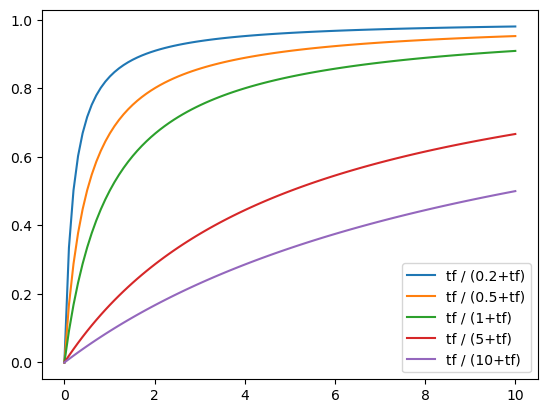

In [128]:
tf = np.linspace(0,10,100)
for k in [0.2, 0.5, 1, 5, 10]:
    plt.plot(tf,tf/ (k+tf), label="tf / (" + str(k)+"+tf)")
plt.legend()
plt.show()

In [20]:
class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        self.vectorizer.fit(X)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = self.y.sum(1).mean()

    def transform(self, q):
        b, k1, avdl = self.b, self.k1, self.avdl

        len_y = self.y.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1 + 1)
        return (numer/ denom).sum(1).A1

In [21]:
cleaned_description = m1.get_and_clean_data()
bm25 = BM25(tf_idf_vectorizer)
bm25.fit(cleaned_description)

score = bm25.transform('aws devops')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())



|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [22]:
score = bm25.transform('aws github')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown() )

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

usage: ipykernel_launcher.py [-h] square
ipykernel_launcher.py: error: argument square: invalid int value: '/Users/yanwarutsuksawat/Library/Jupyter/runtime/kernel-61488dec-9208-46f7-84ce-27e1df9940eb.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'